In [1]:
import comet_ml
import torchvision
import torch

from config import API_KEY

In [2]:
import cv2
import numpy as np
from numpy.random import default_rng
import math
from PIL import Image

def add_irregular_blobs(image, min_radius, max_radius, num_blobs):
    if image.ndim == 3:
        if image.shape[0] in [1, 3]:
            image = np.transpose(image, (1, 2, 0))
    img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    img = img.astype(np.uint8)

    height, width = img.shape[:2]
    rng = default_rng()
    num_points = 12
    mask = np.zeros((height, width), dtype=np.uint8)
    for _ in range(num_blobs):
        base_radius = rng.integers(min_radius, max_radius)
        center_x = rng.integers(base_radius, width - base_radius)
        center_y = rng.integers(base_radius, height - base_radius)
        contour_points = []
        for i in range(num_points):
            angle = 2 * math.pi * i / num_points
            radius = base_radius + rng.integers(-5, 5) 
            x = int(center_x + radius * math.cos(angle))
            y = int(center_y + radius * math.sin(angle))
            contour_points.append((x, y))
        
        contour_points = np.array([contour_points], dtype=np.int32)
        cv2.fillPoly(mask, contour_points, 255)

    mask_rgb = cv2.merge([mask, mask, mask])

    result = cv2.add(img, mask_rgb)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    tensor_image = torch.from_numpy(result)
    tensor_image = tensor_image.permute(2, 0, 1)


    return tensor_image


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import einops

torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4090'

In [4]:
from datasets import load_dataset
from torchvision.transforms import v2


transform = v2.Compose([
    v2.ToTensor(),
    v2.Resize((256, 256)),
])

def preprocess(example):
    example['image'] = example['image'].float() / 255.0
    example['image'] = transform(example['image'])
    return example

gmm_labels = []
gmm_labels = np.load("cluster_labels.npy")

ds = load_dataset("Artificio/WikiArt_Full").with_format('torch')

ds_clustered = {}

for label in set(gmm_labels):
    indices = [i for i, lbl in enumerate(gmm_labels) if lbl == label]
    ds_clustered[label] = ds["train"].select(indices)

e:\repos\inpainting-art\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
e:\repos\inpainting-art\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Dataset({
    features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'resnet50_non_robust_feats', 'resnet50_robust_feats'],
    num_rows: 4673
})


In [5]:
split_datasets = {}

for label, dataset in ds_clustered.items():
    split = dataset.train_test_split(test_size=0.05)
    split_datasets[label] = split 

print(split_datasets)

{0: DatasetDict({
    train: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'resnet50_non_robust_feats', 'resnet50_robust_feats'],
        num_rows: 18859
    })
    test: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'resnet50_non_robust_feats', 'resnet50_robust_feats'],
        num_rows: 993
    })
}), 1: DatasetDict({
    train: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'resnet50_non_robust_feats', 'resnet50_robust_feats'],
        num_rows: 8406
    })
    test: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'resnet50_non_robust_feats', 'resnet50_robust_feats'],
        num_rows: 443
    })
}), 2: DatasetDict({
    train: Dataset({
        featur

In [9]:
from torch.utils.data import DataLoader, random_split

CLUSTER_ID = 2

train_loader = DataLoader(
        split_datasets[CLUSTER_ID]['train'],
        batch_size=30,
        num_workers=12,
        shuffle=True,
        pin_memory=True,
    )

test_loader = DataLoader(
        split_datasets[CLUSTER_ID]['test'],
        batch_size=24,
        num_workers=12,
        shuffle=False,
        pin_memory=True,
    )


In [12]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np
from torchmetrics.image import StructuralSimilarityIndexMeasure

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


def log_images_to_comet(images, experiment, idx, epoch, tr_step):
    grid = make_grid(images, nrow=8, padding=2)
    
    np_grid = grid.permute(1, 2, 0).numpy()

    plt.figure(figsize=(15, 15))
    plt.imshow(np.clip(np_grid, 0, 1))
    plt.axis("off")
    experiment.log_figure(figure_name=f'{tr_step}:{idx}', figure=plt, step=epoch)
    plt.close()

In [ ]:
from tqdm import tqdm

from comet_ml.integration.pytorch import log_model

from torch.cuda.amp import autocast, GradScaler
from torchinfo import summary

from models import UNet, CombinedLoss, add_irregular_blobs
num_epochs = 50

epochs = [x for x in range(10,num_epochs,2)]
if __name__ == '__main__':

    model = UNet(in_channels=3, out_channels=3)
    model.apply(init_weights)
    model.cuda()

    loss_fn = CombinedLoss()

    comet_experiment = comet_ml.Experiment(api_key=API_KEY, project_name='UN_genre')
    comet_experiment.log_parameters(
        {
            'batch_size': train_loader.batch_size,
        }
    )

    summ = summary(model, (1,3,256,256), device='cuda',depth=5)
    comet_experiment.set_model_graph(f'{model.__repr__()}\n{summ}')


    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

    comet_experiment.log_parameter('num_epochs', num_epochs)

    for epoch in range(num_epochs):
        comet_experiment.set_epoch(epoch)

        model.train()
        with comet_experiment.train() as train:
            for idx, batch in tqdm(enumerate(train_loader), desc=f'TRAIN_{epoch}'):
                comet_experiment.set_step(idx + epoch * len(train_loader))

                images = batch['image']
                images_input = []
                for img in images:
                    img_np = img.numpy()
                    img_with_blobs = add_irregular_blobs(img_np, 5, 15, 5)
                    images_input.append(img_with_blobs)

                images_input = torch.stack(images_input)
                images_input = images_input.float().cuda()

                optimizer.zero_grad()
                images = images.cuda()
                predictions = model(images_input)
                l1, per, style = loss_fn(predictions, images / 255.0)
                loss = l1 + per + style

                loss.backward()
                optimizer.step()


                comet_experiment.log_metric('l1_loss', l1)
                comet_experiment.log_metric('per_loss', per)
                comet_experiment.log_metric('style_loss', style)

        model.eval()
        with comet_experiment.test() as test, torch.no_grad() as nograd:
            for idx, batch in tqdm(enumerate(test_loader), desc=f'TEST_{epoch}'):
                comet_experiment.set_step(idx + epoch * len(test_loader))

                images = batch['image']
                images_input = []
                for img in images:
                    img_np = img.numpy()
                    img_with_blobs = add_irregular_blobs(img_np, 5, 15, 5)
                    images_input.append(img_with_blobs)

                images_input = torch.stack(images_input)
                images_input = images_input.float().cuda()

                images = images.cuda()
                predictions = model(images_input)
                l1, per, style = loss_fn(predictions, images / 255.0)
                loss = l1 + per + style


                comet_experiment.log_metric('l1_loss', l1)
                comet_experiment.log_metric('per_loss', per)
                comet_experiment.log_metric('style_loss', style)

                if idx < 2:
                    concatenated = torch.cat([images_input / 255.0, predictions], dim=3).cpu()
                    log_images_to_comet(concatenated, comet_experiment, idx, epoch, 'TEST')


        if epoch in epochs:
            torch.save(model.state_dict(), f"models/{CLUSTER_ID}/model{CLUSTER_ID}_genre_{epoch}.pth")

    log_model(comet_experiment, model, model_name="UNetTest")
    comet_experiment.end()

e:\repos\inpainting-art\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\repos\inpainting-art\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/foxtold/un-genre/4baa5574e653483c9bb8f40a5f10ff07

TRAIN_0: 62it [00:26,  2.77it/s]

C:\Users\riba\AppData\Local\Temp\ipykernel_12224\3066866588.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  TestModel.load_state_dict(torch.load(f'models/{CLUSTER_ID}/mo

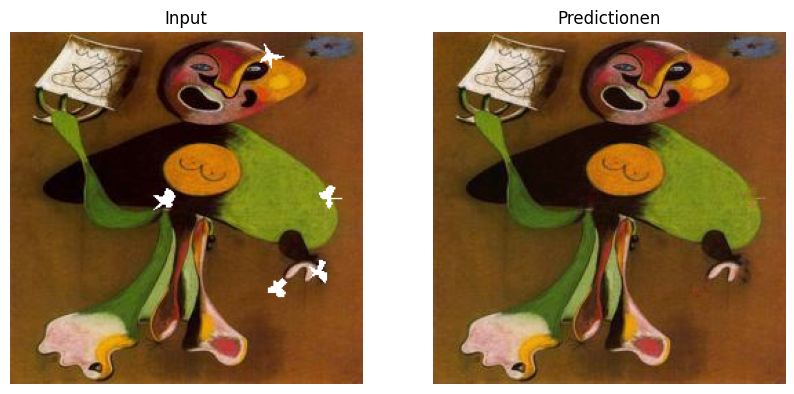

In [16]:
from torchvision.transforms import ToPILImage

TestModel = UNet(in_channels=3, out_channels=3)
TestModel.load_state_dict(torch.load(f'models/{CLUSTER_ID}/model{CLUSTER_ID}_genre_28.pth'))
TestModel = TestModel.cuda()
TestModel.eval()


for idx, image in enumerate(test_loader):
    if idx == 1:
        images = image['image']
        images_input = []
        for img in images:
            img_np = img.numpy()
            img_with_blobs = add_irregular_blobs(img_np, 5, 7, 5)
            images_input.append(img_with_blobs)

        images_input = torch.stack(images_input)
        images_input = images_input.float().cuda()

        predictions = TestModel(images_input)
        transform = ToPILImage()
        images_input = images_input / 255.0

        image_tensor = images_input[0].permute(1, 2, 0)
        image_tensor_2 = predictions[0].detach().permute(1, 2, 0)

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        image_tensor = image_tensor.cpu()
        image_tensor_2 = image_tensor_2.cpu()

        axes[0].imshow(image_tensor)
        axes[0].axis('off')
        axes[0].set_title("Input")

        axes[1].imshow(image_tensor_2)
        axes[1].axis('off')
        axes[1].set_title("Prediction")
        break
